# 

In [26]:
import openai
from openai import OpenAI

# Point to the server
client = OpenAI(base_url="http://localhost:8000/v1", api_key="cltl")

In [48]:
# Sentences to classify
sentences = [
    "I hate you and I hope you fail.",
    "What a beautiful day to go for a walk!",
    "Your idea is stupid and nobody cares."
]

sentences = [
    "#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA Democrats Support Antifa, Muslim Brotherhood, MS13, ISIS, Pedophilia, Child Trafficking, Taxpayer Funded Abortion’s, Election Fraud, Sedition And Treason!!! #LockThemAllUp #WWG1WGA #QAnon @USER URL",
    "#ConstitutionDay is revered by Conservatives, hated by Progressives/Socialist/Democrats that want to change it.",
]

# Build a single prompt
prompt = "Classify each of the following sentences as 'hate' or 'non-hate':\n\n"
for i, s in enumerate(sentences, 1):
    prompt += f"{i}. {s}\n"

prompt += "\nReturn the results in the format:\n<number>. <label>\n"

# Make one request for all sentences
response = client.completions.create(
    model="local model",  # currently unused
    prompt=prompt,
    max_tokens=50,
    temperature=0,
    stop=["Classify", "\n\n"]
)

# Print the raw model output
print(response.choices[0].text.strip())

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
import pandas as pd

# evaluation data
# 15923,"#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA Democrats Support Antifa, Muslim Brotherhood, MS13, ISIS, Pedophilia, Child Trafficking, Taxpayer Funded Abortion’s, Election Fraud, Sedition And Treason!!! #LockThemAllUp #WWG1WGA #QAnon ⁦@USER URL",1
#data = pd.read_csv("Subjectivity_mining_assignment_4_5_data/olid-test.csv")


train_df = pd.read_csv("Subjectivity_mining_assignment_4_5_data/olid-train-small.csv")
test_df  = pd.read_csv("Subjectivity_mining_assignment_4_5_data/olid-test.csv")

In [146]:
df_label0 = test_df[test_df["labels"] == 0].sample(n=100, random_state=42)
df_label1 = test_df[test_df["labels"] == 1].sample(n=100, random_state=42)

df_sampled = pd.concat([df_label0, df_label1])
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_sampled["labels"].value_counts())

labels
0    100
1    100
Name: count, dtype: int64


In [194]:
#fewshot_examples = train_df.sample(n=0, random_state=42)
#fewshot_examples = train_df.sample(n=5, random_state=42)
#fewshot_examples = train_df.sample(n=10, random_state=42)
#fewshot_examples = train_df.sample(n=15, random_state=42)
#fewshot_examples = train_df.sample(n=20, random_state=42)
fewshot_examples = train_df.sample(n=25, random_state=42)


In [166]:
print(len(fewshot_examples))

10


In [167]:
print(fewshot_examples)

          id                                               text  labels
12387  27650  @USER @USER Why is John Kerry running his mout...       0
385    52965        @USER @USER Gun control anyone? #DisarmHate       0
4896   87438                      @USER What manga you reading?       0
3971   67140  @USER You are right. Victoria is on the revers...       0
10394  43102  @USER @USER Thank you @USER . America is respe...       0
12889  25562  @USER They are Antifa democrats disguised as G...       0
4504   27304  @USER @USER @USER How do you come up with all ...       1
3268   56638    @USER bitch my life was flashing before my eyes       1
2439   49314                      @USER Lmao what a joke he is.       0
4688   42416  @USER @USER @USER @USER @USER Looking forward ...       0


In [195]:
def evaluate(prompt_info, data):
    ground_truth = []

    prompt = prompt_info['text'] + f"Classify each of the following sentences as '{prompt_info['labels'][0]}' or '{prompt_info['labels'][1]}':\n\n"

    i = 1
    for id, row in data.iterrows():
        ground_truth.append(row['labels'])
        prompt += f"{i}. {row['text']}\n"
        i+=1

    prompt += "\nReturn the results in this format:\n<number>. <label>\n"


    print("----- Prompt Sent -----")
    print(prompt)

    #make one request for all sentences
    response = client.completions.create(
        model="local model",
        prompt=prompt,
        max_tokens=200,
        temperature=0,
        stop=["Classify", "\n\n"]
    )


    raw_output = response.choices[0].text.strip()
    predicted = raw_output.split("\n")

    print("----- Raw Model Output -----")
    print(predicted)

    final_predictions = []

    for p in predicted:
        try:
            p = p.split(". ")[1].strip().lower()
        except:
            print("⚠️ Skipped line:", p)
            continue

        #! TODO: this is a bit changed to create the lablles option
        if p == prompt_info['labels'][0]:
            final_predictions.append(1)
        elif p == prompt_info['labels'][1]:
            final_predictions.append(0)
        else:
            print("⚠️ Unexpected label:", p)
            continue

    return final_predictions, ground_truth


In [11]:
# get 10:20 from data
#data[10:20]

In [196]:
#prompt 5 = few-shot prompting with randomm
#fewshot_examples = train_df.sample(n=0, random_state=42)
#fewshot_examples = train_df.sample(n=5, random_state=42)
#fewshot_examples = train_df.sample(n=10, random_state=42)
#fewshot_examples = train_df.sample(n=15, random_state=42)
#fewshot_examples = train_df.sample(n=20, random_state=42)
fewshot_examples = train_df.sample(n=25, random_state=42)

prompt5_text = (
    "You are a classifier of hate speech.\n"
    "Below are example tweets with their correct labels:\n\n"
)

for i, row in fewshot_examples.iterrows():
    label = "offensive" if row["labels"] == 1 else "non-offensive"
    prompt5_text += f"\"{row['text']}\" → {label}\n"

prompt5_text += (
    "\nNow classify each of the following new tweets as "
    "'offensive' or 'non-offensive':\n\n"
)

In [142]:
#prompt 6 = few-shot prompting with actual examples from the training data, the small one

prompt6_text = (
    "You are a classifier of hate speech.\n"
    "Below are example tweets with their correct labels:\n\n"
)

examples = [
    ("LIBERALS ARE LIKE MONKEYS THROWING THEIR OWN SHIT AT EVERYTHING", "offensive"),
    ("Smack the shit outta her 😂😂", "offensive"),
    ("HEY BEE ITCH YOU WILL BE INDICTED AND WILL GO TO GITMO", "offensive"),
    ("These mentally deranged Liberals are totally disgusting jerks!", "offensive"),
    ("She is telling to be best to students. Wow ! What a role model she is.", "non-offensive"),
    ("So what I read was gun control doesn’t work and CA politicians are working against Californians sounds about right", "non-offensive"),
    ("He IS Mark Twain in my eyes. Love him.", "non-offensive"),
    ("Nobody interferes and steals elections for liberals in western democracies including America than Soros. Why there is no investigation and are no charges against him? Yet!", "non-offensive"),
]

for text,label in examples:
    prompt6_text += f"\"{text}\" → {label}\n"

prompt6_text += "\nNow classify each of the following new tweets as 'offensive' or 'non-offensive':\n\n"

In [197]:
# Prompts 
!#TODO: changed

prompts = {
    "prompt1": {
        "text": "Classify each of the following sentences as 'offensive' or 'non-offensive':\n\n",
        "labels": ["offensive", "non-offensive"]
    },

    "prompt2": {
        "text": """You are a classifier of hate speech. The following data contains language that is either non offensive or offensive.
Please note these are the definitions of offensive/non-offensive so try to stick to these guidelines.
'offensive': A post that contains insults, threats, or profanity directed towards a person or group.
'non-offensive': A post that is neutral, polite, or does not contain any harmful language.""",
        "labels": ["offensive", "non-offensive"]
    },

    "prompt3": {
        "text": """You are a classifier of hate speech. The following data contains language that is either non-offensive or offensive.
Please note these are the definitions of offensive/non-offensive, so try to stick to these guidelines.
'offensive': all types of expression that incite, promote, spread or justify violence, hatred or discrimination against a person or group of persons, or that denigrates them, by reason of their real or attributed personal characteristics or status such as "race", color, language, religion, nationality, national or ethnic origin, age, disability, sex, gender identity and sexual orientation.
'non-offensive': Negation of offensive definition.""",
        "labels": ["offensive", "non-offensive"]
    },

    "prompt4": {
        "text": """You are a classifier of hate speech. The following data contains language that is either harmful or safe.
Please note these are the definitions of harmful/safe, so try to stick to these guidelines.
'harmful': Language that is offensive, abusive, or hateful, and that can cause emotional or psychological harm to an individual or group.
'safe': Language that does not contain offensive or abusive content, and does not cause harm.""",
        "labels": ["harmful", "safe"]
    },

    "prompt5": {
        "text": prompt5_text,
        "labels": ["offensive", "non-offensive"]
    },

    "prompt6": {
        "text": prompt6_text,
        "labels": ["offensive", "non-offensive"]
    }
}


#to quickly check results
test_slice = df_sampled

all_predictions = []
all_truth_labels = []

for piece in range(0, len(test_slice), 10):
    #pred, truth = evaluate(prompts["prompt5"], test_slice[piece:piece+10])
    predictions, truth = evaluate(prompts["prompt5"], test_slice[piece:piece+10])

    all_predictions.extend(predictions)
    all_truth_labels.extend(truth)

#from sklearn.metrics import classification_report
print("lens:", len(all_truth_labels), len(all_predictions))
print("truth classes:", set(all_truth_labels))
print("predictions  classes:", set(all_predictions))

n = min(len(all_truth_labels), len(all_predictions))
all_truth_labels = all_truth_labels[:n]
all_predictions  = all_predictions[:n]

# print(classification_report(
#     all_truth_labels,
#     all_predictions,
#     labels=[0, 1],
#     target_names=['non-offensive','offensive'],
#     digits=3,
#     zero_division=0
# ))

#from sklearn.metrics import accuracy_score
#accuracy = accuracy_score(all_truth_labels, all_predictions)
#print("Accuracy:", accuracy)

----- Prompt Sent -----
You are a classifier of hate speech.
Below are example tweets with their correct labels:

"@USER @USER Why is John Kerry running his mouth again as if we cared about what he has to say?  I can’t think of a single damn thing Kerry has accomplished besides run his mouth. Trump’s accomplishments exceed anything Kerry could ever dream of. Even before becoming president!" → non-offensive
"@USER @USER Gun control anyone? #DisarmHate" → non-offensive
"@USER What manga you reading?" → non-offensive
"@USER You are right. Victoria is on the reverse...😱" → non-offensive
"@USER @USER Thank you @USER . America is respected again! #MAGA #KAG2018 #VoteRedToSaveAmerica" → non-offensive
"@USER They are Antifa democrats disguised as GOP looking to infiltrate the party. Don't worry though it doesn't take long to figure them out." → non-offensive
"@USER @USER @USER How do you come up with all these lies. You have not done a thing as far as gun control. Open your eyes Obama your her

In [198]:
print(classification_report(
    all_truth_labels,
    all_predictions,
    labels=[0, 1],
    target_names=['non-offensive','offensive'],
    digits=3,
    zero_division=0
))

               precision    recall  f1-score   support

non-offensive      0.534     0.700     0.606       100
    offensive      0.552     0.378     0.448        98

     accuracy                          0.540       198
    macro avg      0.543     0.539     0.527       198
 weighted avg      0.543     0.540     0.528       198



In [163]:
#experiment for prompt 5

#have to fix it
#the loop does not work, so I am going to do it by hand and add the classifcation report per run instead of loop

from sklearn.metrics import accuracy_score

shots = [0, 5, 10, 15, 20, 25] #same as the paper
accuracies = []

for shot in shots:
    if shot > 0:
        fewshot_examples = train_df.sample(n= shot, random_state=42)
    else:
        fewshot_examples = pd.DataFrame()

    prompt_k = (
        "You are a classifier of hate speech.\n"
        "Below are example tweets with their correct labels:\n\n"
    )
    for i, row in fewshot_examples.iterrows():
        label = "offensive" if row["labels"] == 1 else "non-offensive"
        prompt_k += f"\"{row['text']}\" → {label}\n"

    prompt_k += "\nNow classify each of the following new tweets as 'offensive' or 'non-offensive':\n\n"

    predictions, truth = evaluate(prompt_k, test_slice)

    #accuracy = accuracy_score(truth[:len(predictions)], predictions)
    #accuracies.append(accuracy)
    #print(f"{shot}-shot accuracy: {accuracy:.3f}")

    print(f"\n=== {shot}-shot classification report ===")

    print(classification_report(
        truth[:len(predictions)],
        predictions,
        labels=[0, 1],
        target_names=['non-offensive', 'offensive'],
        digits=3,
        zero_division=0
    ))


----- Prompt Sent -----
You are a classifier of hate speech.
Below are example tweets with their correct labels:


Now classify each of the following new tweets as 'offensive' or 'non-offensive':

Classify each of the following sentences as 'offensive' or 'non-offensive':

1. @USER Hey Jimmy @USER The View had Norm on.   THE VIEW!!!!!  You're sad.
2. @USER I read this as If you are a straight white male forget about being partnered.""
3. @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER Proud to follow all.  Thanks for the follow-back!
4. @USER @USER Obviously they do not care who they ruin due to their attacks on conservatives.... the left is out of control and blind as a 🦇!!!!!
5. @USER @USER Dr Merck just following orders. Abysmal little pharma troll he is.
6. @USER @USER @USER Socialism once its implemented has historically had only one effective stop measure and that has been civil war. Knowing that 

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 2048 tokens, however you requested 6923 tokens (6723 in your prompt; 200 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [159]:
# import matplotlib.pyplot as plt
#
# print("Shots:", shots)
# print("Accuracies:", accuracies)
#
# plt.figure(figsize=(6,4))
# plt.plot(shots, accuracies, marker='o', linewidth=2)
# plt.title("Accuracy vs Number of Shots")
# plt.xlabel("Number of shots")
# plt.ylabel("Accuracy")
# plt.ylim(0,1)
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()



In [173]:
#experiment for prompt 6

#have

examples = [
    #offensive
    ("LIBERALS ARE LIKE MONKEYS THROWING THEIR OWN SHIT AT EVERYTHING", "offensive"),
    ("Smack the shit outta her 😂😂", "offensive"),
    ("HEY BEE ITCH YOU WILL BE INDICTED AND WILL GO TO GITMO", "offensive"),
    ("These mentally deranged Liberals are totally disgusting jerks!", "offensive"),
    ("@USER I like how her boobs have the same mass as her belly XD", "offensive"),
    ("@USER No prison time for you. You're going to get McCain-ed 😂🤣😂 #DeathPenalty #Treason #Pedogate #MAGA #QAnon", "offensive"),
    ("@USER You liberals... smh...tweeting stupid shit! Trump order elimination of isis (Obama didn’t)…", "offensive"),
    ("@USER There is no such thing as an Antifa warrior. They are all coward bitches. Marcus Smart is tougher than that by far", "offensive"),
    ("@USER Clown", "offensive"),
    ("@USER I'm not an asshole libtard.", "offensive"),
    ("@USER you're a jerk. Attacking julie for standing by her husband. You're just like all the other liberals want to ruin peoples lives.", "offensive"),
    ("@USER Just because his best stats season was at 34 doesn’t mean he’s the greatest pl midfielder 🤣 fuck off", "offensive"),
    #non-offensive
    ("She is telling to be best to students. Wow ! What a role model she is.", "non-offensive"),
    ("So what I read was gun control doesn’t work and CA politicians are working against Californians sounds about right", "non-offensive"),
    ("He IS Mark Twain in my eyes. Love him.", "non-offensive"),
    ("Nobody interferes and steals elections for liberals in western democracies including America than Soros. Why there is no investigation and are no charges against him? Yet!", "non-offensive"),
    ("$10 B/W commissions are still available! Please DM if you are interested! #artistforhire", "non-offensive"),
    ("@USER @USER @USER @USER @USER It'll be the lack of a range of good olive oil that will cause my mayhem", "non-offensive"),
    ("@USER Legally you need to take 15 min break every 2 hours and a lunch after 4 if you stream for more than 5 hours", "non-offensive"),
    ("@USER She is soooo pretty!!!!!!", "non-offensive"),
    ("@USER Antifa is expressly anti Nazi. Is Nunes identifying with Nazis?", "non-offensive"),
    ("@USER I am truly sorry that you are having a rough day. I hope it gets better for you. I am doing fantastic.", "non-offensive"),
    ("@USER And there I was thinking I couldn't like you any more than I already did... Brilliant. 😀❤️💉❤️😀", "non-offensive"),
    ("@USER What's that GIF called?", "non-offensive"),
]

def build_prompt6(ex_subset):
    prompt = (
        "You are a classifier of hate speech.\n"
        "Below are example tweets with their correct labels:\n\n"
    )
    for text, lab in ex_subset:
        prompt += f"\"{text}\" → {lab}\n"
    prompt += (
        "\nNow classify each of the following new tweets as "
        "'offensive' or 'non-offensive':\n\n"
    )
    return prompt


test_slice = df_sampled

from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

shots = [0, 4, 8, 12, 16, 20, 24]

accuracy = []

for shot in shots:
    curated_subset = examples[:shot]
    prompt6_text  = build_prompt6(curated_subset)

    prediction, truth = evaluate(prompt6_text, test_slice)

    n = min(len(prediction), len(truth))
    if n == 0:
        print(f"\n=== {shot}-shot: No predictions returned ===\n")
        accuracies.append(np.nan)
        continue

    from sklearn.metrics import accuracy_score
    acc = accuracy_score(truth[:n], predictions[:n])
    accuracies.append(acc)

    print(f"\n=== {shot}-shot classification report ===")
    print(classification_report(
        truth[:n],
        predictions[:n],
        labels=[0,1],
        target_names=['non-offensive','offensive'],
        digits=3,
        zero_division=0
    ))
    #     acc = np.nan
    # else:
    #     accuracy = accuracy_score(truth[:n], prediction[:n])
    #
    # accuracy.append(acc)
    # print(f"{shot}-shot accuracy: {accuracy:.3f}")

# plt.figure()
# plt.plot(shots, accuracy, marker='o')
# plt.xlabel("Number of relevant examples in the prompt")
# plt.ylabel("Accuracy")
# plt.title("Prompt 6: Relevant Few-shot — Examples vs Accuracy")
# plt.xticks(shots)
# plt.grid(True)
# plt.show()


TypeError: string indices must be integers, not 'str'

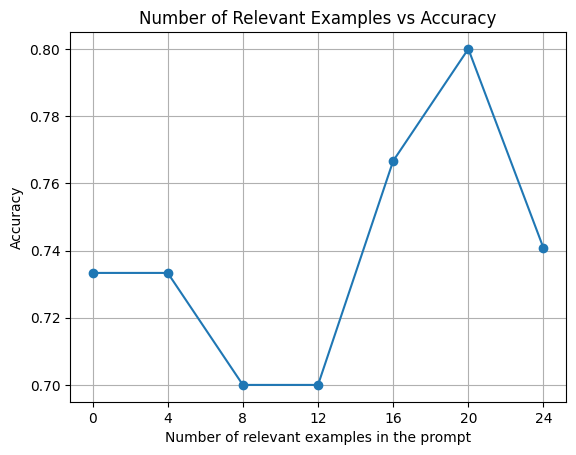

In [97]:
plt.figure()
plt.plot(shots, accuracy, marker='o')
plt.xlabel("Number of relevant examples in the prompt")
plt.ylabel("Accuracy")
plt.title("Number of Relevant Examples vs Accuracy")
plt.xticks(shots)
plt.grid(True)
plt.show()

In [14]:
#print(classification_report(all_truth_labels, all_predictions , target_names=['non-hate', 'hate']))

In [39]:
# from sklearn.metrics import classification_report
# import pandas as pd
#
# #! TODO: this is changed, doesnt run correctly,
# # need a way to loop through the prompts and use the labels with the prompt to create a table like above
#
# def run_all_prompts(prompts, data, step=10):
#     results = {}
#
#     for pname, ptext in prompts.items():
#         print(f"\n===== Running {pname} =====")
#
#         all_predictions = []
#         all_truth_labels = []
#
#         for piece in range(0, len(data), step):
#             pred, truth = evaluate(ptext, data[piece:piece+step])
#             all_predictions.extend(pred)
#             all_truth_labels.extend(truth)
#
#
#         report = classification_report(
#             all_truth_labels,
#             all_predictions,
#             target_names=['non-offensive/safe', 'offensive/harmful'],
#             output_dict=True
#         )
#         results[pname] = report
#
#
#         print(pd.DataFrame(report).transpose())
#
#     return results
# results = run_all_prompts(prompts, data)